## <p style="text-align: center;"> Intervertebral Disc Labeling With Learning Shape Information, A Look Once Approach </p>
####   <p style="text-align: center;">  R Azad, M Heidari, J Cohen-Adad, E Adeli, D Merhof </p>
####   <p style="text-align: center;">  RWTH Aachen, MILA lab, and Standford University </p>
####   <p style="text-align: center;">  MICCAI 2022 </p>

### Abstract
Detecting intervertebral disc location often comes with FP and FN prediction. Therefore, a general method is required to handle this challenge. To this end, we propose a permutation invariant look once model. In the next sub-sections, we will discuss the motivation and idea.


### 1. Motivation
A principal limitation of many cohort studies is that as they utilize the local maximum technique to take out the position of the vetebral discs in 2D space on top of the prediction masks, they encounter a substantial false positive rate. Exhaustive search tree, template matching, point coordinate condition are among the popular algorithms proposed to eliminate the FP rate. However, these approaches usually lack the computational efficiency and render a poor candidate recovery. Therefore, a general method is required to handle this challenge. In this work, we aim to mitigate this limitation by bolstering the post-processing step in intervertebral disc labeling procedure. The main idea is that, inspired by the idea of YOLO, we propose a permutation invariant look once model to increase True Positive (TP) rate while reducing the False Negative (FN) detection. We re-formulate the problem by a modified version of PointNet model which is invariant to certain geometric transformations (e.g, rotation). To the best of our knowledge, this is the first post-processing algorithm that processes the whole prediction in once without any iteration (look once).

(-0.5, 301.5, 366.5, -0.5)

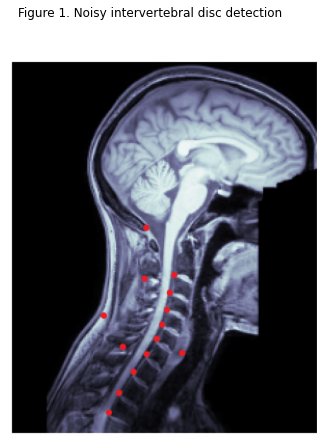

In [20]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np
img = Image.open( './images/noisy_prediction.png' )
img.load()
img = np.asarray( img, dtype="int32" )
fig = plt.figure(figsize = (15, 7))
plt.imshow(img, cmap='bone')
fig.suptitle('Figure 1. Noisy intervertebral disc detection', fontsize=12)
plt.axis('off')

### 2. Problem Formulation
Lets consider we have an input image I with N intervertebral disc location and the prediction model estimated $M$ intervertebral disc candidate, usually $M>N$ and $M∈R^2$ (for example 2D position). Except for the pose estimation approach, the prediction model does not provide any label for the predicted intervertebral discs (only a prediction for intervertebral disc regardless of their order). To consider the problem in a general form, we assume that the model is not able to provide the semantic labeling.  Now the objective is to recover $N$ points out $M$ which best matches to the ground truth intervertebral disc location. Since the semantic information is not provided for the predicted points, we consider it as a set of $M$ points (no order).  The set is an unstructured data and selecting $N$ out of $M$ requires processing of:
\begin{equation}
\frac{(M)!}{(M)! (M-N)!} 
\end{equation}  
Permutation. The processing time will takes long time if $M≫N$. To overcome this limitation it is highly desirable that the post-processing algorithm process the whole prediction in once without any iteration (look once).

### 3. Implementation

#### 3.1 Importing the required libraries 

In [21]:
pip install plyfile

Note: you may need to restart the kernel to use updated packages.


In [80]:
from __future__ import print_function
import torch.nn as nn
import torch
import torch.nn.parallel
import torch.utils.data
from   torch.autograd import Variable
import torch.nn.functional as F
from train_utils import *
import argparse
import os
import random
import torch
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader 
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import cv2
import random 
from torch.utils.data import Dataset
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

#### 3.2 Proposed approach
As explained before the predicted intervertebral disc locations is an unstructured collection of points. Therefore, the deep model needs to be permutation invariant. In other words, any order of points should result in the same result. The proposed structure (modified version of (PointNet model) is depicted in figure 2. The proposed method consists of two-stream, where in the first stream (upper side) a series of feature transformation layers followed by the multilayer perceptron (MLP) is designed to encode the input coordinate into a high-level representational space. Where the objective of this representation is to create a discriminative embedding space to characterize each point by a hidden dependency underlying the input data. Intrinsically, the transformation layer in this stream assures the robustness of the representation to the noisy samples and provides a less sensitive transformation to an affine geometrical transformation (e.g. rotation). Inspired by the permutation invariance characteristics, the MLP layer deploys a shared kernel to produce a set of representations independent of their order. Eventually, on top of the generated feature map, a symmetric function (global pooling) is utilized to capture the shared signature among all points. We concatenate the global information with the local representation of each point to describe each intervertebral disc candidate. This representation more or less contains the general structure of the data, however, it still requires pair-wise relational information. To include such information, we create a geometrical representation. To this end, using the fully connected layers, we learn the embedding parameters to model the long-range geometrical dependency. The main objective of this layer is to capture the geometrical relation between points and fed it to the scaler function. We include the sigmoid function on top of the generated representation to form an attention vector. This attention vector performs the re-calibrate process and adaptively scales the generated feature map. The generated final representation is then fed to the single-layer perceptron model to perform the softmax operation and classify each candidate.

Text(0.5, 0.98, 'Figure 2. Proposed structure for the post-processing step.')

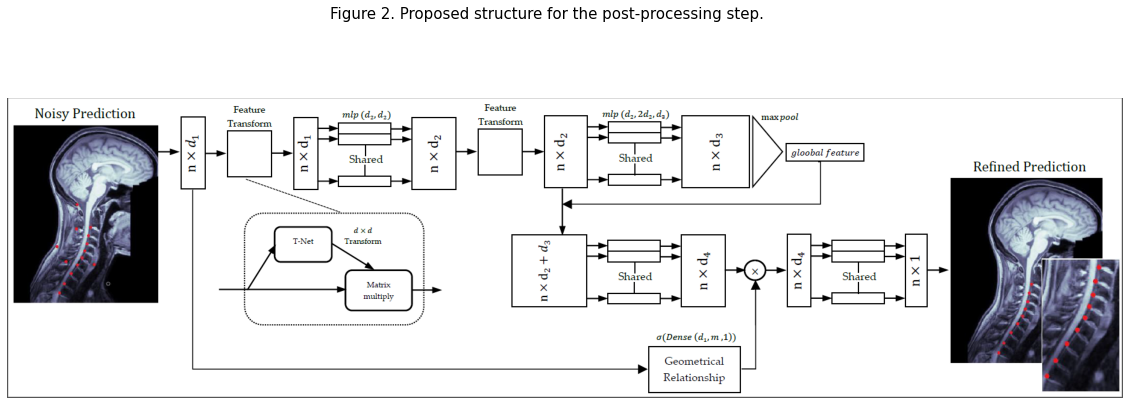

In [23]:
img = Image.open('./images/postprocess_method.png')
img.load()
img = np.asarray( img, dtype="int32" )
fig = plt.figure(figsize = (20, 7))
plt.imshow(img, cmap='bone')
plt.axis('off')
fig.suptitle('Figure 2. Proposed structure for the post-processing step.', fontsize=15)

#### Model implementation

In [24]:
class STN3d(nn.Module):
    def __init__(self):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.array([1,0,0,0,1,0,0,0,1]).astype(np.float32))).view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x


class STNkd(nn.Module):
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1,self.k*self.k).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

class PointNetfeat(nn.Module):
    def __init__(self, global_feat = True, feature_transform = False):
        super(PointNetfeat, self).__init__()
        self.stn = STNkd(k=2)
        self.conv1 = torch.nn.Conv1d(2, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.global_feat = global_feat
        self.feature_transform = feature_transform
        if self.feature_transform:
            self.fstn = STNkd(k=64)
           

    def forward(self, x):
        n_pts = x.size()[2]
        trans = self.stn(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        if self.feature_transform:
            trans_feat = self.fstn(x)
            x = x.transpose(2,1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2,1)
        else:
            trans_feat = None

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans, trans_feat
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, n_pts)
            return torch.cat([x, pointfeat], 1), trans, trans_feat

class PointNetDenseCls(nn.Module):
    def __init__(self, k = 2, feature_transform=False):
        super(PointNetDenseCls, self).__init__()
        self.k = k
        self.feature_transform=feature_transform
        self.feat = PointNetfeat(global_feat=False, feature_transform=feature_transform)
        self.conv1 = torch.nn.Conv1d(1088, 512, 1)
        self.conv2 = torch.nn.Conv1d(512, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, self.k, 1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        self.convr1 = torch.nn.Conv1d(2, 1, 1)
        self.liner1 = nn.Linear(20, 20)

    def forward(self, x):
        batchsize = x.size()[0]
        n_pts = x.size()[2]
        relational = F.sigmoid(self.liner1(self.convr1(x)))
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        relational = relational.repeat(1, 128, 1)
        x = x * relational
        x = self.conv4(x)
        x = x.transpose(2,1).contiguous()
        x = F.log_softmax(x.view(-1,self.k), dim=-1)
        x = x.view(batchsize, n_pts, self.k)
        return x, trans, trans_feat

def feature_transform_regularizer(trans):
    d = trans.size()[1]
    batchsize = trans.size()[0]
    I = torch.eye(d)[None, :, :]
    if trans.is_cuda:
        I = I.cuda()
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2,1)) - I, dim=(1,2)))
    return loss

#### 3.3 Training and Test data loader
We devide the Spine generic dataset into a training and test sets (similra to the pose estimation approach) then we generate the noisy prediction samples using the training set. The data preparation process follows the same process as explained in the pose estimation paper. below we load the training and test sets.  

In [25]:
## Load the prepared dataset
with open('./prepared_data/prepared_trainset_t1', 'rb') as file_pi:
     full = pickle.load(file_pi)
full[0] = full[0][:, :, :, :, 0]    

## Create a dataset loader
full_dataset_train = image_Dataset(image_paths=full[0], target_paths=full[1], use_flip = False)
MRI_train_loader = DataLoader(full_dataset_train, batch_size= 106, shuffle=False, num_workers=0)

## Load the prepared dataset
with open('./prepared_data/prepared_testset_t1_full', 'rb') as file_pi:
     full = pickle.load(file_pi)
full[0] = full[0][:, :, :, :, 0]    

## Create a dataset loader
full_dataset_test = image_Dataset(image_paths=full[0], target_paths=full[1], use_flip = False)
MRI_test_loader = DataLoader(full_dataset_test, batch_size= 10, shuffle=False, num_workers=0)


#### 3.4 Some samples of the training set are visualized bellow

(106, 11, 256, 256)


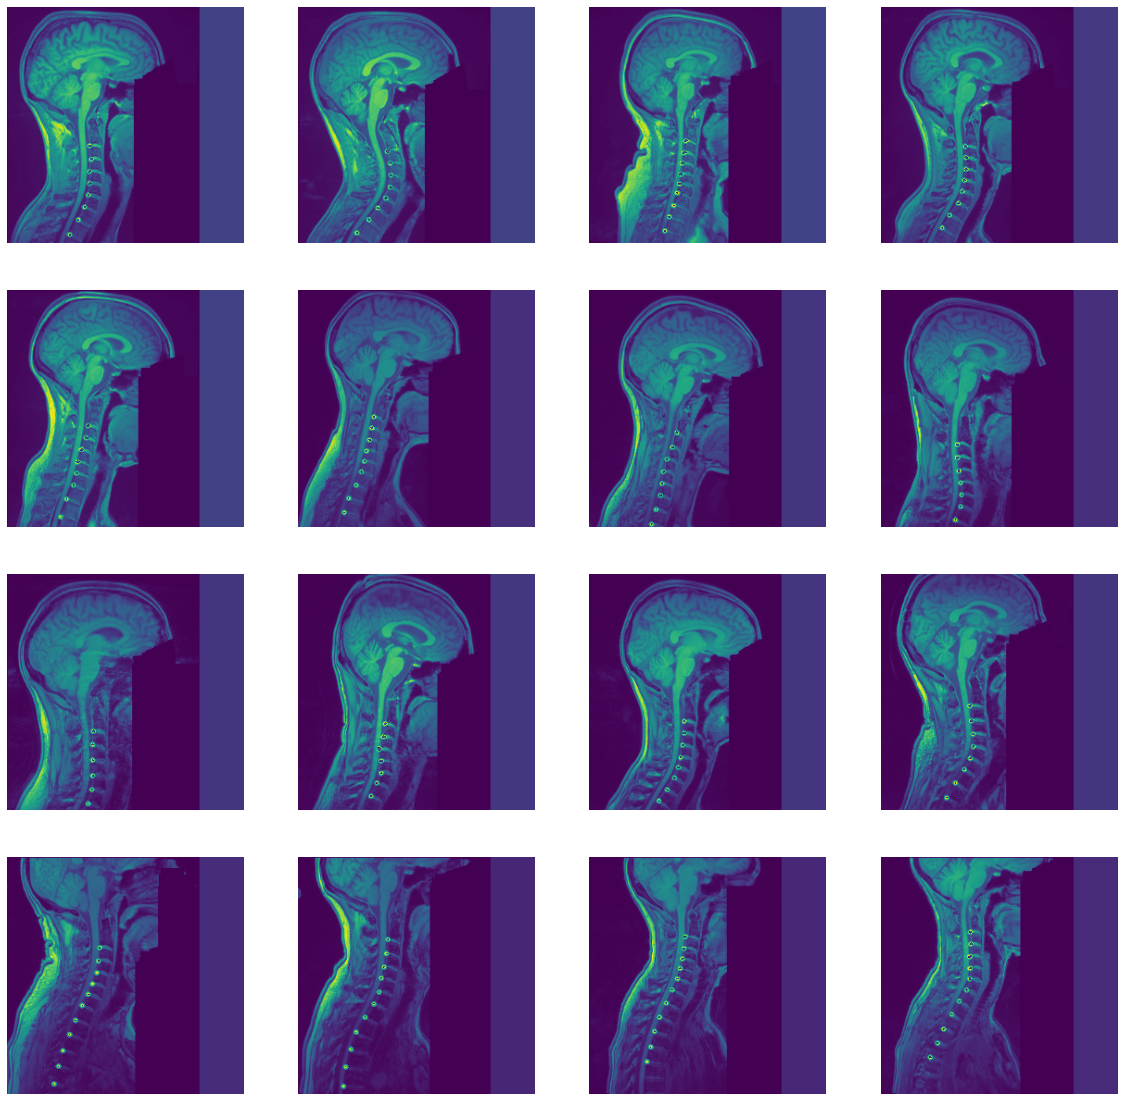

In [26]:
for i, (img, target_img, _, _) in enumerate(MRI_train_loader):
    img        = img.numpy()
    target_img = target_img.numpy()
    break
   
# img = np.einsum('lkij->lijk', img)    
img = img[:,0]
fig, ax = plt.subplots(4, 4,figsize=[20,20])
plt.axis('off')
T = 0
print(target_img.shape)
for idx in range(4):
    for idy in range(4):
        img2 = np.rot90(np.uint8(img[T]*255))
        msk  = np.rot90(np.uint8(np.sum(target_img[T], axis=0)*255))
        img2 += msk
        ax[idx, idy].imshow(img2)
        ax[idx, idy].axis('off')
        T += 1
  

### 3.5 Generate Noisy Prediction
we assume that the model $f$ with parameters $ \Theta $ is able to detect the intervertebral disc location, however there are exist some error in the prediction mask. Thus, we model this assumption using the gussian noise around each intervertebral disc. To this end, we creat a 2D guassian distribution around each intervertebral disc to generate new points, if the new point has distance higher than $D_1$ to the intervertebral disc locations and in the meanwhile distance $D_2$ to the generated points then we add it to the generated points list. Bellow we implemented the function.

In [27]:
def get_noisy_prediction(mask, Count = 25, Only_skeleton = False):
    Noisy_skeleton = np.zeros((Count, 2))
    Noisy_label    = np.zeros((Count, 1), dtype= np.int64)
    
    num_labels, labels_im, states, centers = cv2.connectedComponentsWithStats(mask)
    centers = [t[::-1] for t in centers]
    skelet = np.zeros((len(centers)-1, 2))
    skelet[0:len(centers)-1] = centers[1:]
    C = Count-len(centers)+1

    dist_th  = mask.shape[0]*0.07
    dist_thg = mask.shape[0]*0.06

    joints = skelet

    noise_point_list = []
    while True:
        for joint in joints:
            joint_noise_num = int(np.round(np.random.rand() * np.random.randint(0, 5)))
            for jn in range(joint_noise_num):
                mean = joint
                cov = np.random.rand(2,2)
                while 1:
                    noise_point = 35*(np.random.multivariate_normal([0, 0], cov).T) + mean
                    if np.min(noise_point) < 0 or np.max(noise_point)>255: continue
                    dists   = [np.linalg.norm(j - noise_point, 2) for j in joints]
                    dists_g = [np.linalg.norm(j - noise_point, 2) for j in noise_point_list]
                    dists_g.append(np.Inf)
                    if  np.min(dists) > dist_th and np.min(dists_g) > dist_thg:
                        noise_point_list.append(noise_point)
                        break
        if len(noise_point_list) >= C:
            break
                
    random.shuffle(noise_point_list)
    noise_point_list   = noise_point_list[:C]
    T                  = len(centers)-1 
    Noisy_skeleton[:T] = centers[1:]
    Noisy_label[:T]    = 1
    for ni in noise_point_list:
        Noisy_skeleton[T] = ni
        T += 1
    
    if Only_skeleton:
        mask_noise = 0
    else:
        mask_noise = np.zeros_like(mask)
        for ni in Noisy_skeleton:
            mask_noise[int(ni[0]), int(ni[1])] = 255
        mask_noise = cv2.GaussianBlur(mask_noise, (7, 7), sigmaX=1, sigmaY=1)
        mask_noise = mask_noise / mask_noise.max()
    ## Add noise to intervertebral location to avoid overfitting    
    Noisy_skeleton = np.array(Noisy_skeleton) + np.random.randn(len(Noisy_skeleton), 2)*1
    
    ## Normalize points
    Normjoint = np.linalg.norm(Noisy_skeleton[0]-Noisy_skeleton[4])
    for idx in range(1, len(Noisy_skeleton)):
        Noisy_skeleton[idx] = (Noisy_skeleton[idx]-Noisy_skeleton[0]) / Normjoint
    
    Noisy_skeleton[0] *= 0   
    
    ## Randomize the point order to avoid possible overfitting        
    indx_c             = random.sample(range(0, len(Noisy_label)), len(Noisy_label))
    Noisy_label        = Noisy_label[indx_c]
    Noisy_skeleton     = Noisy_skeleton[indx_c,:]
        

    return Noisy_skeleton, Noisy_label+1, mask_noise
    
def get_noisy_prediction_batch(mask, Count = 25, Only_skeleton = False):
    b_Skelet = np.ones((mask.shape[0], Count, 2))
    b_Label  = np.zeros((mask.shape[0], Count, 1))
    b_masked = np.zeros((mask.shape[0], mask.shape[2], mask.shape[3]))
    for idx in range(mask.shape[0]): 
        msk = np.sum(mask[idx], axis = 0)    
        msk = np.uint8(np.where(msk>0, 1, 0))
        msk = np.rot90(msk)
        Skelet, Label, masked = get_noisy_prediction(msk, Count = Count, Only_skeleton = Only_skeleton)
        b_Skelet[idx] = Skelet
        b_Label[idx]  = Label
        b_masked[idx] = masked
    
    b_Skelet = torch.Tensor(b_Skelet)
    b_Skelet = b_Skelet.transpose(2, 1)
    b_Label  = np.squeeze(b_Label)
    b_Label  = torch.tensor(np.int64(b_Label)) 
    return b_Skelet, b_Label, b_masked    

    

### 3.6 Visualize some sampels of the generated noisy prediction

<ipython-input-27-fbd98666cbad>:24: RuntimeWarning: covariance is not positive-semidefinite.
  noise_point = 35*(np.random.multivariate_normal([0, 0], cov).T) + mean


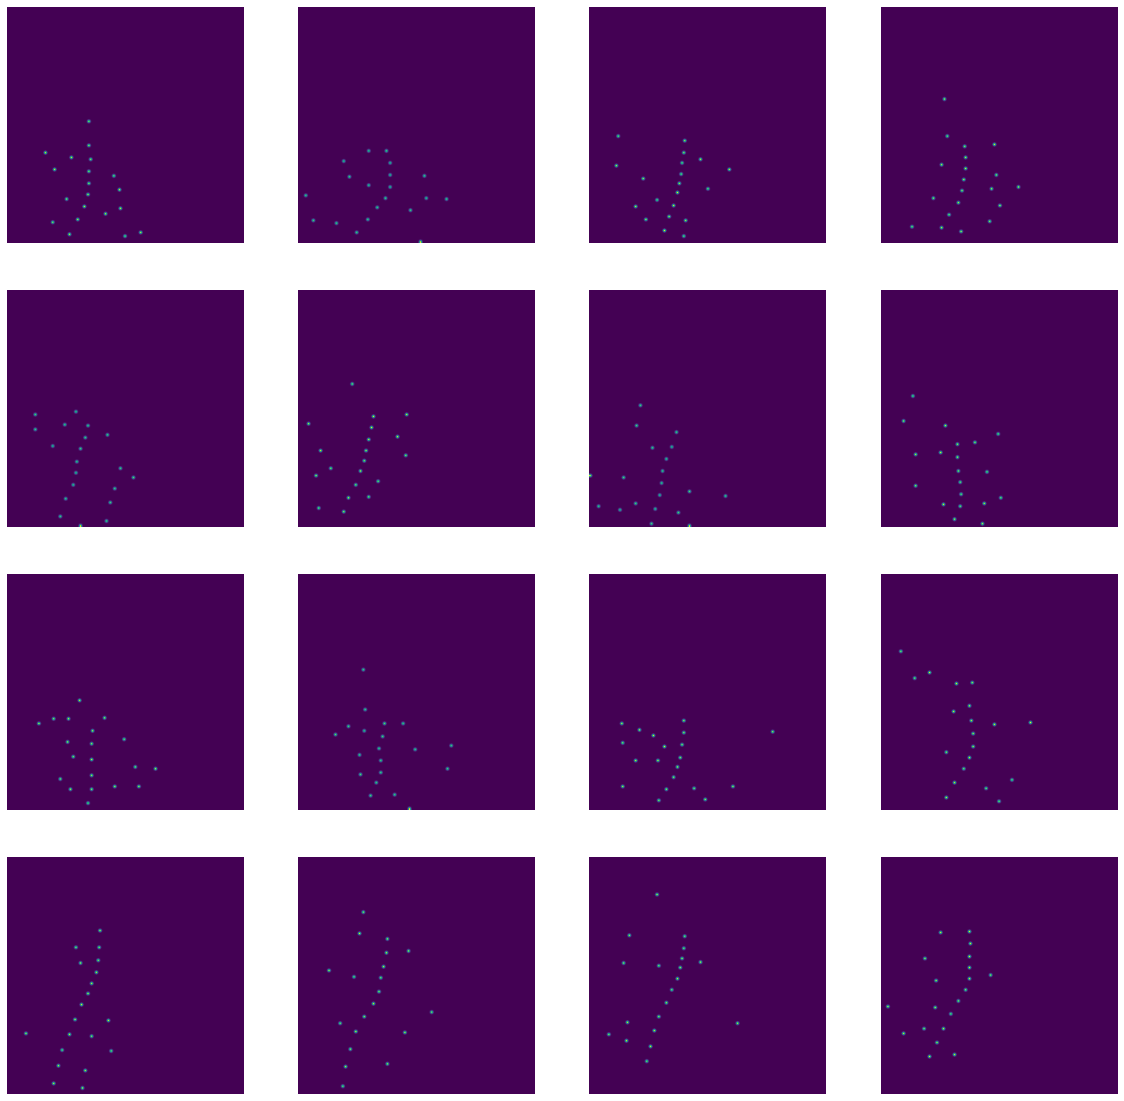

In [28]:
for i, (_, target_img, _, _) in enumerate(MRI_train_loader):
    target_img = target_img.numpy()
    points, target, masked = get_noisy_prediction_batch(target_img[:20], Count = 20, Only_skeleton = False)
    break
    
fig, ax = plt.subplots(4,4,figsize=[20,20])
T = 0
for idx in range(4):
    for idy in range(4):
        ax[idx, idy].imshow(np.uint8(masked[T]*50))
        ax[idx, idy].axis('off')
        T += 1
   

### 3.7 Creat the model 


In [29]:
classifier = PointNetDenseCls(k=2, feature_transform=False)
optimizer = optim.Adam(classifier.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
classifier.cuda()


PointNetDenseCls(
  (feat): PointNetfeat(
    (stn): STNkd(
      (conv1): Conv1d(2, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=4, bias=True)
      (relu): ReLU()
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv1): Conv1d(2, 64, kernel_size=(1,), stride=(1,))
  

#### New loss functions (not included yet)

In [30]:
def mindis(p, skeleton):
    dists=[np.linalg.norm(tp-p) for tp in skeleton]
    return min(dists)+0.1
          
def distance_loss(points, y_true, y_pred):
    loss = 0
    skeleton = [s for i, s in enumerate(points) if y_true[i]==1]
    for idx in range(len(y_true)):
        loss += torch.abs(y_pred[idx]- y_true[idx])* mindis(points[idx], skeleton)
    return loss
    
    

#### side by side visualization function

In [31]:
def sbs_show(p, gt, pre, title = 'result', Count = 1):
    points = p.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()
    pre = pre.detach().cpu().numpy()
    for ids in range(Count):
        c1 =[]
        c2 =[]
        X = points[ids, 1,:]
        Y = points[ids, 0,:]
        for idx in range(20):
            if gt[(ids*20)+idx]==1:
               c1.append('red')
            else:
               c1.append('blue') 
        for idx in range(20):
            if pre[(ids*20)+idx]==1:
               c2.append('red')
            else:
               c2.append('blue')     

        plt.figure()
        _, axs = plt.subplots(1, 2, figsize = (21, 7))
        axs[0].scatter(X, -1*Y, color=c1)
        axs[1].scatter(X, -1*Y, color=c2)
        axs[0].set_title('Ground truth')        
        axs[1].set_title(title)
        axs[0].axis('off')
        axs[1].axis('off')
        plt.show()


### 3.8 Trainin process
We train the model for 100 epochs using the Adam optimizer with learning rate $1e-4$

In [14]:
num_classes     = 2
nepoch          = 50
num_batch       = 2
best_loss       = 100
load_model      = False
loss_history    = []

if load_model:
    checkpoint = torch.load('./weigh_classifier_intervertebral2')
    classifier.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_epoch   = checkpoint['epoch']
    best_loss     = checkpoint['loss']
    loss_history  = checkpoint['loss_history']
    


for epoch in range(nepoch):
    scheduler.step()
    for i, (_, target_img, _, _) in enumerate(MRI_train_loader):
        target_img = target_img.numpy()
        points, target, masked = get_noisy_prediction_batch(target_img, Count = 20, Only_skeleton = True)
        points, target = points.cuda(), target.cuda()
        optimizer.zero_grad()
        classifier = classifier.train()
        pred, trans, trans_feat = classifier(points)
        pred = pred.view(-1, num_classes)
        target = target.view(-1, 1)[:, 0] - 1
        loss = F.nll_loss(pred, target)
        loss.backward()
        optimizer.step()
        pred_choice = pred.data.max(1)[1]
        correct = pred_choice.eq(target.data).cpu().sum()
        loss_history.append(loss.item())  
        if best_loss>loss.item():
            best_loss = loss.item()
            torch.save(
            {
            'epoch': epoch,
            'loss_history': loss_history,    
            'model_state_dict': classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.cpu(),
            }, './weigh_classifier_intervertebral2')            
 
#         if epoch%5==1:
#            sbs_show(points, target, pred_choice, title = f'Epoch: {epoch} >> Itteration {i+1} >> Loss:{loss.item()}')
        
        
        
        print('[%d: %d/%d] train loss: %f accuracy: %f' % (epoch, i, num_batch, loss.item(), correct.item()/float(points.shape[0]*points.shape[2])))


/work/scratch/azad/anaconda3/envs/pytorch_cuda11/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-9-fbd98666cbad>:24: RuntimeWarning: covariance is not positive-semidefinite.
  noise_point = 35*(np.random.multivariate_normal([0, 0], cov).T) + mean
/work/scratch/azad/anaconda3/envs/pytorch_cuda11/lib/python3.9/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sig

[0: 0/2] train loss: 0.685531 accuracy: 0.595755
[0: 1/2] train loss: 0.671425 accuracy: 0.604717
[1: 0/2] train loss: 0.667000 accuracy: 0.599057
[1: 1/2] train loss: 0.664877 accuracy: 0.605660
[2: 0/2] train loss: 0.657602 accuracy: 0.604245
[2: 1/2] train loss: 0.654191 accuracy: 0.618396
[3: 0/2] train loss: 0.649995 accuracy: 0.616509
[3: 1/2] train loss: 0.645499 accuracy: 0.628302
[4: 0/2] train loss: 0.640464 accuracy: 0.619811
[4: 1/2] train loss: 0.631513 accuracy: 0.644811
[5: 0/2] train loss: 0.625175 accuracy: 0.645283
[5: 1/2] train loss: 0.615656 accuracy: 0.661321
[6: 0/2] train loss: 0.614220 accuracy: 0.648585
[6: 1/2] train loss: 0.606228 accuracy: 0.670755
[7: 0/2] train loss: 0.601928 accuracy: 0.669340
[7: 1/2] train loss: 0.588762 accuracy: 0.683962
[8: 0/2] train loss: 0.580777 accuracy: 0.703774
[8: 1/2] train loss: 0.573665 accuracy: 0.700000
[9: 0/2] train loss: 0.561130 accuracy: 0.724528
[9: 1/2] train loss: 0.545758 accuracy: 0.749057
[10: 0/2] train loss

KeyboardInterrupt: 

### 3.9 Inference process
We evaluate the trained model on the test set. First we add a noisy points to the test set then we use the model to predict the correct intervertebral disc location. 

<ipython-input-27-fbd98666cbad>:24: RuntimeWarning: covariance is not positive-semidefinite.
  noise_point = 35*(np.random.multivariate_normal([0, 0], cov).T) + mean


<Figure size 432x288 with 0 Axes>

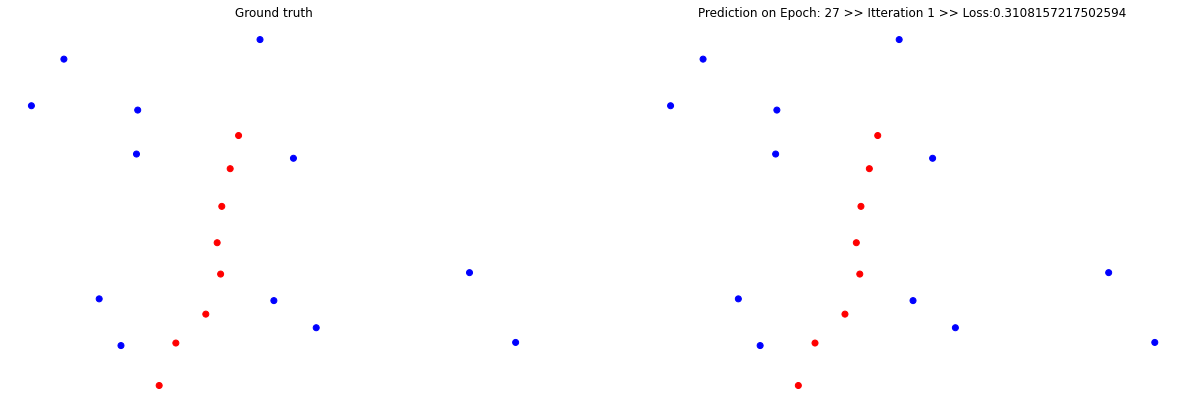

<Figure size 432x288 with 0 Axes>

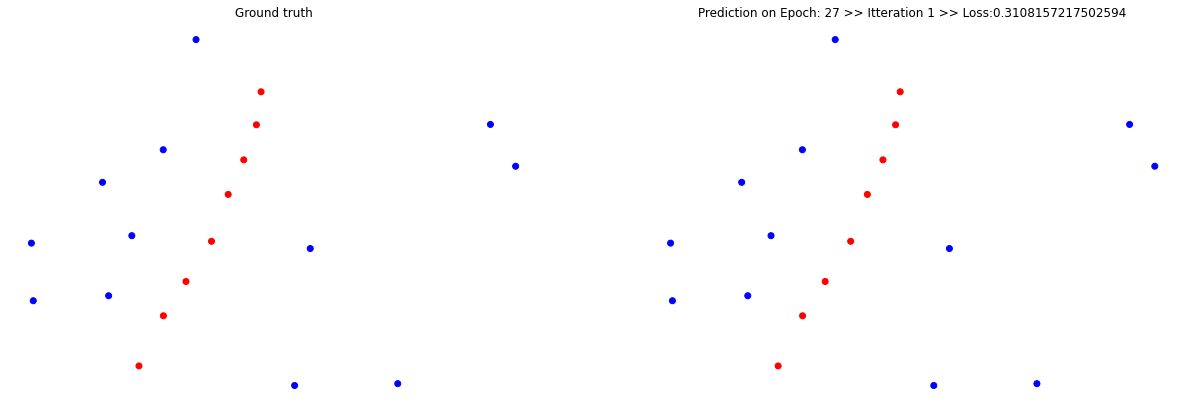

In [35]:
### Sample prediction
load_model  = True
Samples     = 5
if load_model:
    checkpoint = torch.load('./weigh_classifier_intervertebral2')
    classifier.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_epoch = checkpoint['epoch']
    best_loss = checkpoint['loss']
for i, (_, target_img, _, _) in enumerate(MRI_test_loader): #MRI_train_loader
        target_img = target_img[1:Samples]
        target_img = target_img.numpy()
        points, target, masked = get_noisy_prediction_batch(target_img, Count = 20, Only_skeleton = False)
        points, target = points.cuda(), target.cuda()
        optimizer.zero_grad()
        classifier = classifier.eval()
        pred, trans, trans_feat = classifier(points)
        pred = pred.view(-1, num_classes)
        target = target.view(-1, 1)[:, 0] - 1
        loss = F.nll_loss(pred, target)
        pred_choice = pred.data.max(1)[1]
        correct = pred_choice.eq(target.data).cpu().sum()        
        sbs_show(points, target, pred_choice, title = f'Prediction on Epoch: {epoch} >> Itteration {i+1} >> Loss:{loss.item()}', Count = 2)
        break
        

In [116]:
### Performance
import time

## Load the prepared dataset
with open('./prepared_data/prepared_testset_t1_full', 'rb') as file_pi:
     full = pickle.load(file_pi)
full[0] = full[0][:, :, :, :, 0]    

## Create a dataset loader
batchsize = 1
full_dataset_test = image_Dataset(image_paths=full[0], target_paths=full[1], use_flip = False)
MRI_test_loader = DataLoader(full_dataset_test, batch_size= batchsize, shuffle=False, num_workers=0)


load_model  = True
Samples     = 1
Total_acc = 0.0
ttp = 0.0
if load_model:
    checkpoint = torch.load('./weigh_classifier_intervertebral2')
    classifier.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_epoch = checkpoint['epoch']
    best_loss = checkpoint['loss']
for i, (_, target_img, _, _) in enumerate(MRI_test_loader): #MRI_train_loader
        target_img = target_img
        target_img = target_img.numpy()
        points, target, masked = get_noisy_prediction_batch(target_img, Count = 20, Only_skeleton = False)
        points, target = points.cuda(), target.cuda()
        optimizer.zero_grad()
        classifier = classifier.eval()
        start_time = time.time()
        pred, trans, trans_feat = classifier(points)
        print(f"--- %s Inference time for batch size {batchsize} seconds ---" % (time.time() - start_time))
        pred = pred.view(-1, num_classes)
        target = target.view(-1, 1)[:, 0] - 1
        loss = F.nll_loss(pred, target)
        pred_choice = pred.data.max(1)[1]
        correct = pred_choice.eq(target.data).cpu().sum()     
        acc = correct/len(pred_choice)
        ttp += target.data.sum()
        Total_acc += acc

Total_acc /= (i+1)  
print(f'Average number of intervertebral disc in each image>> {ttp/(i+1)}')
        

--- 0.002603769302368164 Inference time for batch size 1 seconds ---
--- 0.0025589466094970703 Inference time for batch size 1 seconds ---
--- 0.0025708675384521484 Inference time for batch size 1 seconds ---
--- 0.002669095993041992 Inference time for batch size 1 seconds ---
--- 0.0025365352630615234 Inference time for batch size 1 seconds ---
--- 0.0025634765625 Inference time for batch size 1 seconds ---
--- 0.002560853958129883 Inference time for batch size 1 seconds ---
--- 0.0025708675384521484 Inference time for batch size 1 seconds ---
--- 0.0024514198303222656 Inference time for batch size 1 seconds ---
--- 0.0025556087493896484 Inference time for batch size 1 seconds ---
--- 0.002608776092529297 Inference time for batch size 1 seconds ---
--- 0.002568483352661133 Inference time for batch size 1 seconds ---
--- 0.0025572776794433594 Inference time for batch size 1 seconds ---
--- 0.002567291259765625 Inference time for batch size 1 seconds ---
--- 0.0025169849395751953 Infere

In [119]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

def get_scores(y_true, y_scores):
    
    global AUC_ROC, AUC_prec_rec, accuracy, specificity, sensitivity, F1_score
    
    metrics = []
    fpr, tpr, thresholds = roc_curve((y_true), y_scores)
    AUC_ROC += roc_auc_score(y_true, y_scores)
    #Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    precision = np.fliplr([precision])[0] 
    recall = np.fliplr([recall])[0]
    AUC_prec_rec += np.trapz(precision,recall)

    confusion = confusion_matrix(y_true, y_scores)
    accuracy += 0
    if float(np.sum(confusion))!=0:
        accuracy += float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))

    specificity += 0
    if float(confusion[0,0]+confusion[0,1])!=0:
        specificity += float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])

    sensitivity += 0
    if float(confusion[1,1]+confusion[1,0])!=0:
        sensitivity += float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])

    #F1 score
    F1_score += f1_score(y_true, y_scores, labels=None, average='binary', sample_weight=None)
    return AUC_ROC, AUC_prec_rec, accuracy, specificity, sensitivity, F1_score




In [149]:
### Performance
import time

## Load the prepared dataset
with open('./prepared_data/prepared_testset_t1_full', 'rb') as file_pi:
     full = pickle.load(file_pi)
full[0] = full[0][:, :, :, :, 0]    

## Create a dataset loader
batchsize = 1
full_dataset_test = image_Dataset(image_paths=full[0], target_paths=full[1], use_flip = False)
MRI_test_loader = DataLoader(full_dataset_test, batch_size= batchsize, shuffle=False, num_workers=0)


load_model  = True
Samples     = 1
Total_acc = 0.0
ttp = 0.0
if load_model:
    checkpoint = torch.load('./weigh_classifier_intervertebral2')
    classifier.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_epoch = checkpoint['epoch']
    best_loss = checkpoint['loss']
AUC_ROC, AUC_prec_rec, accuracy, specificity, sensitivity, F1_score = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
for i, (_, target_img, _, _) in enumerate(MRI_test_loader): #MRI_train_loader
        target_img = target_img
        target_img = target_img.numpy()
        points, target, masked = get_noisy_prediction_batch(target_img, Count = 20, Only_skeleton = False)
        points, target = points.cuda(), target.cuda()
        optimizer.zero_grad()
        classifier = classifier.eval()
        start_time = time.time()
        pred, trans, trans_feat = classifier(points)
        pred = pred.view(-1, num_classes)
        target = target.view(-1, 1)[:, 0] - 1
        loss = F.nll_loss(pred, target)
        pred_choice = pred.data.max(1)[1]
        AUC_ROC, AUC_prec_rec, accuracy, specificity, sensitivity, F1_score = get_scores(target.cpu(), pred_choice.cpu())

AUC_ROC, AUC_prec_rec, accuracy, specificity, sensitivity, precision, jaccard_index, F1_score = AUC_ROC/(i+1), AUC_prec_rec/(i+1), accuracy/(i+1), specificity/(i+1), sensitivity/(i+1), precision/(i+1), jaccard_index/(i+1), F1_score/(i+1)
        
print(f'AUC_ROC>>{AUC_ROC} AUC_prec_rec>>{AUC_prec_rec} accuracy>>{accuracy} specificity>>{specificity} sensitivity>>{sensitivity} F1_score>>{F1_score}')            
        

AUC_ROC>>0.9552307735000042 AUC_prec_rec>>0.9613187738187736 accuracy>>0.9589743589743588 specificity>>0.9676349291733908 sensitivity>>0.9428266178266179 F1_score>>0.9423451036275518


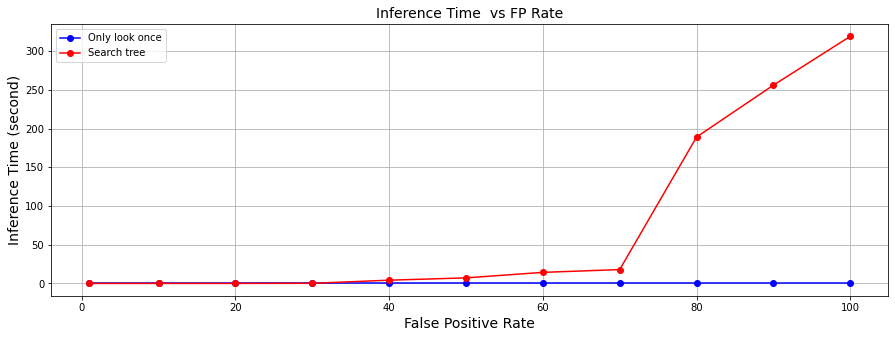

In [153]:
## Inference time diagram based on the experiments
Data = {'FP': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        'InferenceTime_loo': [0.0025, 0.0025, 0.0026, 0.0026, 0.0027, 0.0028, 0.0028, 0.0029, 0.0030, 0.0030, 0.0031],
        'InferenceTime_tree': [0.030, 0.045, 0.055, 0.190, 4.2, 7.2, 14.3, 17.9, 189, 256, 319],
       }
  
df = pd.DataFrame(Data,columns=['FP','InferenceTime_loo','InferenceTime_tree'])
  
fig = plt.figure(figsize=[15,5])

plt.plot(df['FP'], df['InferenceTime_loo'], color='blue', marker='o', label="Only look once")
plt.plot(df['FP'], df['InferenceTime_tree'], color='red', marker='o', label="Search tree")
# plt.plot(df['FP'], (df['InferenceTime_loo']+0.01), color='green', marker='o')
plt.title('Inference Time  vs FP Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('Inference Time (second)', fontsize=14)
plt.legend(loc="upper left")
plt.grid(True)
plt.show()
plt.show()

Joint Stanford and MILA group